# GoFast. Исследование бизнеса 

<strong>Цели исследования:</strong>

Проанализировать данные, найти возможные ошибки, проверить несколько гипотез, и выяснить возможные точки роста бизнеса;

<strong>Гипотезы:</strong>
- Пользователи с подпиской совершают более длинные поездки;
- Пользователи с подпиской приносят больше выручки;
- 3130 метров - оптимальное время поездки с точки зрения износа самоката;

<strong>Также нужно оценить:</strong>
- Сколько промокодов на бесплатный период нужно разослать, чтобы с вероятностью 95% получить 100 клиентов;
- Какова вероятность того, что из миллиона отправленных писем письмо откроют не более 399500 пользователей;

<strong>Ход исследования:</strong>

Полученные данные необходимо проверить на качество - привести данные к необходимому типу, избавиться от явных и неявных дублей, избавиться от нетипичных значений, искажающих картину. После этого можно будет объединить данные, провести исследовательский анализ данных и проверить несколько статистических гипотез.

<strong>Этапы:</strong>

- Получение данных
- Предобработка данных (изменение типов, удаление дубликатов и аномалий, расчет дополнительных столбцов)
- Изучение параметров очищенных и обогащенных данных
- Проверка гипотез
- Общий вывод

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt

random_state = 42

## Загрузка данных

Считаем данные, оценим их визуально и изучим информацию о каждом датасете.

In [3]:
users = pd.read_csv('/datasets/users_go.csv')
display(users.head())
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
display(rides.head())
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions.head())
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


На первый взгляд данные в порядке. Отсутствуют пропущенные значения, типы данных корректные. 

## Предобработка данных

### Обработка даты


Чтобы удобнее было производить вычисления, приведем колонку с датами к типу данных date и выделим месяц.

In [6]:
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.month
rides_min = rides['date'].min().date()
rides_max = rides['date'].max().date()
display(rides.head())
print(f'Имеем данные за период {rides_min} - {rides_max}')

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Имеем данные за период 2021-01-01 - 2021-12-30


### Обработка дубликатов

Посмотрим, есть ли в таблицах явные и неявные дубли и избавимся от них в случае необходимости

In [7]:
print(f"""Явных дублей в таблицах:
users - {users.duplicated().sum()}
rides - {rides.duplicated().sum()}
subscriptions - {subscriptions.duplicated().sum()}""")

Явных дублей в таблицах:
users - 31
rides - 0
subscriptions - 0


In [8]:
users = users.drop_duplicates()
print('В таблице users мы обнаружили несколько дублей. Лучше от них избавиться\n')
print(f"""Проверка:
users - {users.duplicated().sum()}
rides - {rides.duplicated().sum()}
subscriptions - {subscriptions.duplicated().sum()}""")

В таблице users мы обнаружили несколько дублей. Лучше от них избавиться

Проверка:
users - 0
rides - 0
subscriptions - 0


In [9]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

<strong>Вывод:</strong> 
- В таблице <i>users</i> мы обнаружили несколько дублирующихся строк, и избавились от них.
- Неявные дубли в названий городов не обнаружены.

## Исследовательский анализ данных

Посмотрим на данные, удастся ли найти какие-то особенности и закономерности

### Города

In [10]:
users.groupby('city')['user_id'].count().sort_values(ascending=False).reset_index()

,city,user_id
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


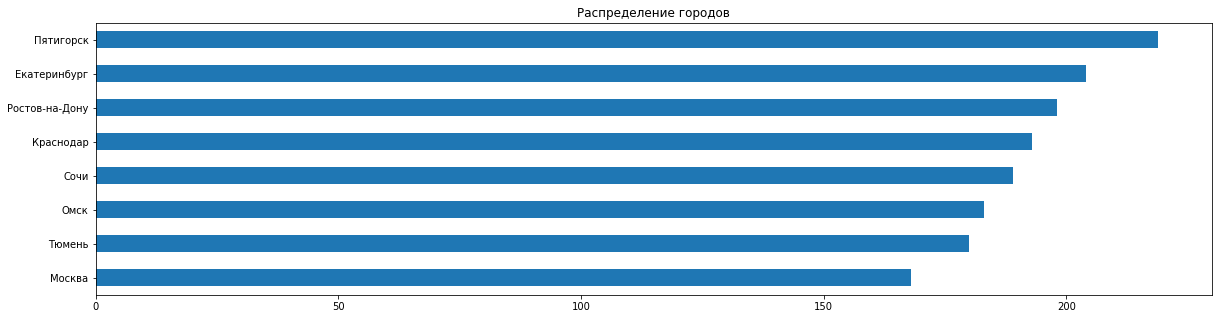

В целом распределение пользователей по городам довольно равномерно. 
Город-лидер по количеству пользоватетей - Пятигорск. 
Меньше всего пользователей в Москве.


In [11]:
cities_chart_data = users['city'].value_counts().sort_values()
cities_chart_data.plot.barh(figsize=(20, 5))
plt.title('Распределение городов')
plt.show()
print('''В целом распределение пользователей по городам довольно равномерно. 
Город-лидер по количеству пользоватетей - Пятигорск. 
Меньше всего пользователей в Москве.''')

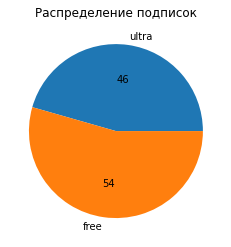

Ситуация с подписками очень похожа. Бесплатной подпиской пользуются незначительно больше пользователей


In [12]:
ax = users.groupby('subscription_type')['user_id'].count().sort_values().plot(kind='pie', autopct = '%.0f');
ax.set(ylabel=None)
plt.title('Распределение подписок')
plt.show()
print('''Ситуация с подписками очень похожа. Бесплатной подпиской пользуются незначительно больше пользователей''')

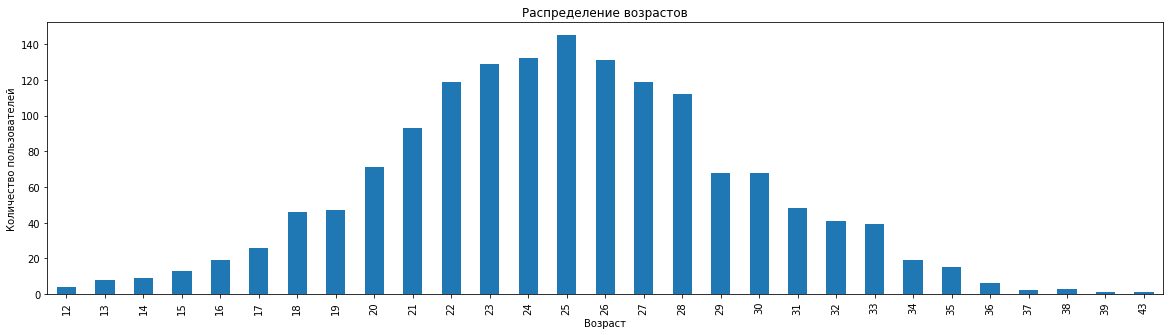

Расределение возрастов похоже на нормальное вокруг среднего 25 лет, что логично

Статистика возраста:


count    1534.0
mean       24.9
std         4.6
min        12.0
25%        22.0
50%        25.0
75%        28.0
max        43.0
Name: age, dtype: float64

In [13]:
ax = users.groupby('age')['user_id'].count().plot(kind='bar', figsize=(20, 5));
ax.set(xlabel='Возраст')
ax.set(ylabel='Количество пользователей')
plt.title('Распределение возрастов')
plt.show()
print('''Расределение возрастов похоже на нормальное вокруг среднего 25 лет, что логично\n''')
print('Статистика возраста:')
users['age'].describe().round(1)

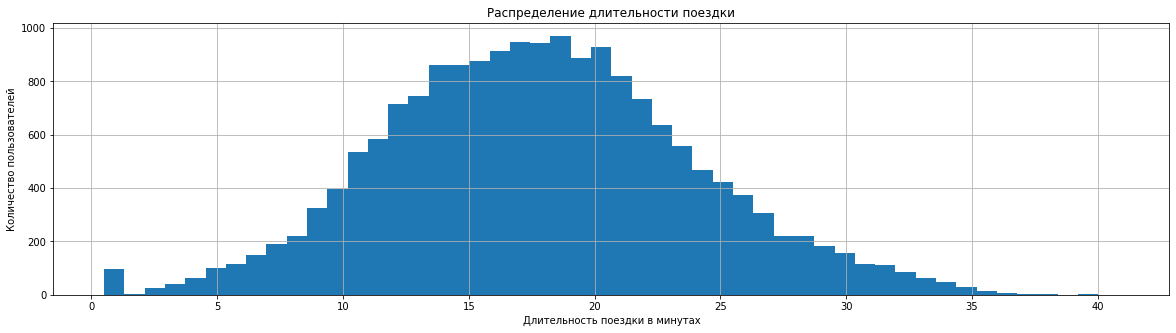

Длительность поездки тоже распределена нормально вокруг среднего в районе 17 минут.
Есть странный пик в районе нуля, нужно посмотреть на него повнимательнее


In [13]:
ax = rides['duration'].hist(bins=50, figsize=(20, 5));
plt.title('Распределение длительности поездки')
ax.set(xlabel='Длительность поездки в минутах', ylabel='Количество пользователей')
plt.show()
print('''Длительность поездки тоже распределена нормально вокруг среднего в районе 17 минут.
Есть странный пик в районе нуля, нужно посмотреть на него повнимательнее''')

In [14]:
display(rides[rides['duration'] < 1].head())
print(len(rides[rides['duration'] < 1]), 'странных поездок по полминуты. Во время которых проехали по 4-5 км.')
print('Это аномалии, от которых следует избавиться')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


95 странных поездок по полминуты. Во время которых проехали по 4-5 км.
Это аномалии, от которых следует избавиться


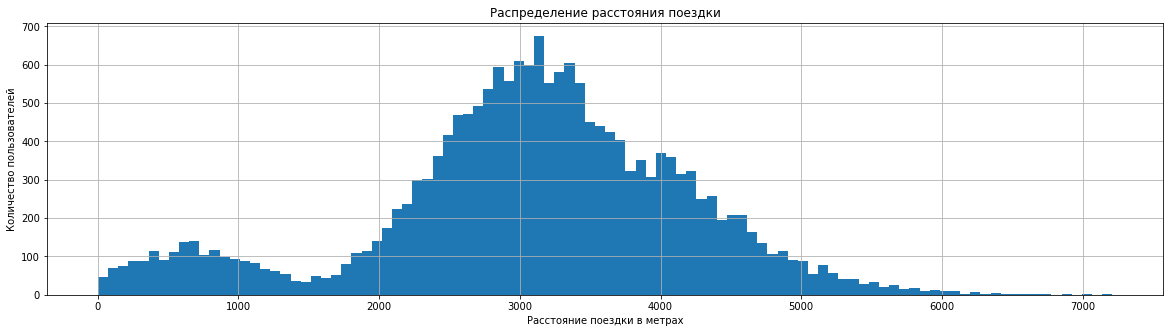

Расстояния поездок имеют два пика - возможно стоит рассмотреть их отдельно


In [15]:
ax = rides['distance'].hist(bins=100, figsize=(20, 5));
plt.title('Распределение расстояния поездки')
ax.set(xlabel='Расстояние поездки в метрах', ylabel='Количество пользователей')
plt.show()
print('''Расстояния поездок имеют два пика - возможно стоит рассмотреть их отдельно''')

## Объединение данных

Объединим данные из всех датасетов в один, после разделим на разные подписки.

In [16]:
total_df = (rides
            .merge(users, how='left', on='user_id')
            .merge(subscriptions, how='left', on='subscription_type'))

ultra = total_df[total_df['subscription_type'] == 'ultra']
free = total_df[total_df['subscription_type'] == 'free']

# Проверим, не задублировались ли строки
total_df.shape[0] == rides.shape[0]

True

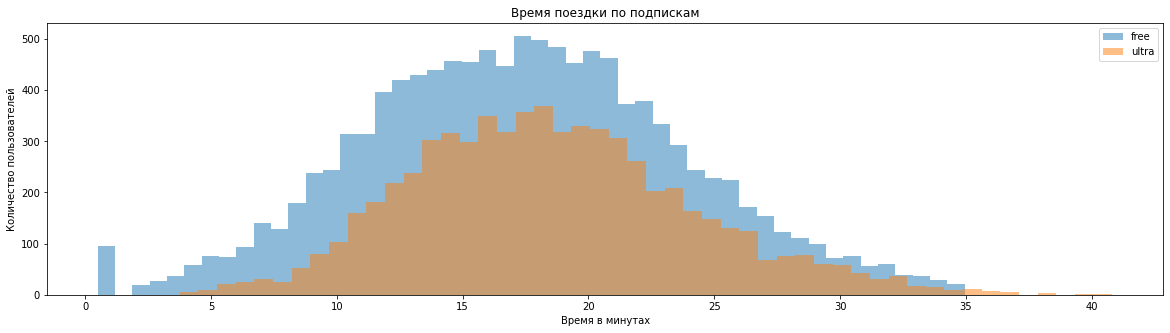

Распределения очень похожи. В подписке free больше пользователей и аномалия в районе нуля


In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Время поездки по подпискам')
ax.hist(free['duration'], bins=50, alpha=0.5, label='free')
ax.hist(ultra['duration'], bins=50, alpha=0.5, label='ultra')
ax.set(xlabel='Время в минутах', ylabel='Количество пользователей')
ax.legend()
plt.show()
print('Распределения очень похожи. В подписке free больше пользователей и аномалия в районе нуля')

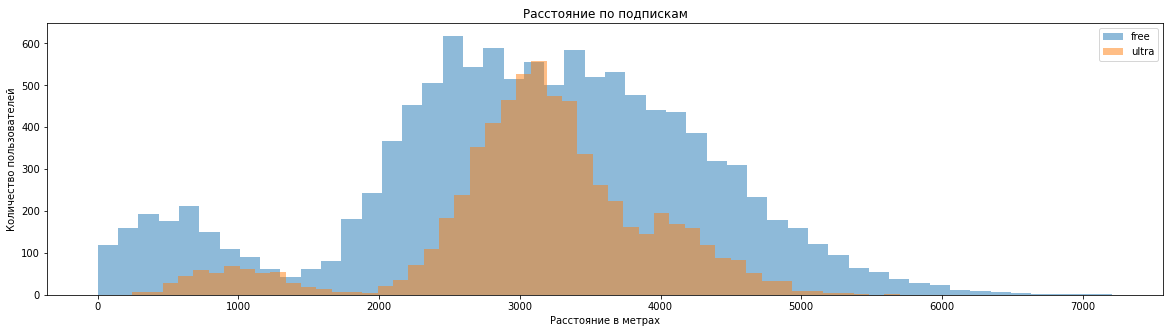

Видно, что дисперсии распределений сильно различаются. Оба имеют два пика


In [18]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Расстояние по подпискам')
ax.hist(free['distance'], bins=50, alpha=0.5, label='free')
ax.hist(ultra['distance'], bins=50, alpha=0.5, label='ultra')
ax.set(xlabel='Расстояние в метрах', ylabel='Количество пользователей')
ax.legend()
plt.show()
print('Видно, что дисперсии распределений сильно различаются. Оба имеют два пика')

## Подсчёт выручки

Найдём суммарное время поездки, расстояние, количество поездок и выручке, полученную за каждого пользователя в каждом месяце.

In [19]:
# Одна строчка в датасете - это одна поездка. Можем посчитать её стоимость без учета подписки
# Подписка оплачивается раз в месяц, её посчитаем после агрегации данных
total_df['ex_fee_revenue'] = (np.ceil(total_df['duration']) 
                              * total_df['minute_price'] 
                              + total_df['start_ride_price'])

user_stat = (total_df.pivot_table(index=['user_id', 'month', 'subscription_type'], 
                     aggfunc={'distance': 'sum', 
                              'duration': 'sum',
                              'ex_fee_revenue': 'sum',
                              'user_id': 'count'})
             .rename(columns={'user_id': 'rides'})
             .reset_index())

ultra_fee = subscriptions.query('subscription_type == "ultra"')['subscription_fee']

user_stat['revenue'] = user_stat.apply(lambda x: x['ex_fee_revenue'] + ultra_fee
                                       if x['subscription_type'] == 'ultra' 
                                       else x['ex_fee_revenue'], 
                                       axis=1)
user_stat = user_stat.drop('ex_fee_revenue', axis=1)

user_stat.head()

,user_id,month,subscription_type,distance,duration,rides,revenue
0,1,1,ultra,7027.511294,41.416640,2,451.0
1,1,4,ultra,754.159807,6.232113,1,241.0
2,1,8,ultra,6723.470560,44.776802,2,475.0
3,1,10,ultra,5809.911100,31.578017,2,391.0
4,1,11,ultra,7003.499363,53.397424,3,535.0


## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Тратят ли пользователи с подпиской больше времени на поездки?

Сравним средние двух выборок, чтобы ответить на этот вопрос.

<strong>Нулевая гипотеза:</strong> в среднем длительность поездок пользователей с подпиской и без не различаются<br>
<strong>Альтернативная гипотеза:</strong> в среднем длительность поездок пользователей с подпиской выше, чем у пользователей без подписки.

Прежде, чем проводить исследование, нужно обработать несколько особенностей данных:
1. Поскольку размеры датасетов различаются, возьмём из них случайные выборки одинакового размера. 
2. Также, исходя из графиков, мы можем увидеть, что дисперсии датасетов различаются, укажем это.
3. В датасете *free* есть аномалии с длительностью поездки в полминуты. Избавимся от них.

In [20]:
free_duration = free[free['duration'] > 0.5]['duration'].sample(n=6000, random_state=random_state)
ultra_duration = ultra['duration'].sample(n=6000, random_state=random_state)

results = st.ttest_ind(ultra_duration, 
                       free_duration, 
                       alternative='greater', 
                       equal_var=False)
alpha = 0.05 

print(f'''Среднее время поездки:
free: {free_duration.mean().round()}
ultra: {ultra_duration.mean().round()}\n''')

print('p-значение:', results.pvalue, '\n')

if results.pvalue < alpha:
    print('''Отвергаем нулевую гипотезу. Пользователи с подпиской действительно тратят больше времени на поездки.
Такие пользователи выгоднее для компании. Следует популяризировать подписку ultra среди пользователей без подписки,
а пользователей с подпиской стараться максимально удерживать''')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Среднее время поездки:
free: 17.0
ultra: 19.0

p-значение: 3.869950729014655e-23 

Отвергаем нулевую гипотезу. Пользователи с подпиской действительно тратят больше времени на поездки.
Такие пользователи выгоднее для компании. Следует популяризировать подписку ultra среди пользователей без подписки,
а пользователей с подпиской стараться максимально удерживать


### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката?

Сравним среднее выборки *ultra* с целевым показателем, чтобы ответить на этот вопрос.

<strong>Нулевая гипотеза:</strong> среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров<br>
<strong>Альтернативная гипотеза:</strong> среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

In [21]:
ultra_distance = ultra['distance']

interested_value = 3130

results = st.ttest_1samp(ultra_distance, 
                         interested_value, 
                         alternative='greater')
alpha = 0.05 

print(f'''Среднее расстояние поездки:
ultra: {ultra_distance.mean().round()}\n''')

print('p-значение:', results.pvalue, '\n')

if results.pvalue < alpha:
    print('''Отвергаем нулевую гипотезу. Среднее расстояние, которое пользователи проезжают за одну поездку, 
превышает 3130 метров. Расстояние, выбранное как оптимальное для износа самоката, стоит увеличить.''')
else:
    print('''Не получилось отвергнуть нулевую гипотезу. 
Среднее расстояние, которое пользователи проезжают за одну поездку действительно не превышает 3130 метров.''') 

Среднее расстояние поездки:
ultra: 3115.0

p-значение: 0.9195368847849785 

Не получилось отвергнуть нулевую гипотезу. 
Среднее расстояние, которое пользователи проезжают за одну поездку действительно не превышает 3130 метров.


### Какие пользователи приносят больше выручки?

Сравним средние двух выборок, чтобы ответить на этот вопрос.

<strong>Нулевая гипотеза:</strong> в среднем помесячная выручка от пользователей с подпиской не отличаются от пользователей без неё<br>
<strong>Альтернативная гипотеза:</strong> помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [22]:
free_revenue = user_stat[user_stat['subscription_type'] == 'free']['revenue'].sample(n=4500, 
                                                                                     random_state=random_state)
ultra_revenue = user_stat[user_stat['subscription_type'] == 'ultra']['revenue'].sample(n=4500, 
                                                                                       random_state=random_state)

results = st.ttest_ind(ultra_revenue, 
                       free_revenue, 
                       alternative='greater', 
                       equal_var=False)
alpha = 0.05 

print(f'''Средняя выручка:
free: {free_revenue.mean().round()}
ultra: {ultra_revenue.mean().round()}\n''')

print('p-значение:', results.pvalue, '\n')

if results.pvalue < alpha:
    print('''Отвергаем нулевую гипотезу. Помесячная выручка пользователей с подпиской выше, чем пользователей без неё.
Нам следует максимально удерживать пользователей с подпиской и популяризировать её среди пользователей без неё.''')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Средняя выручка:
free: 326.0
ultra: 363.0

p-значение: 2.6754923673120238e-34 

Отвергаем нулевую гипотезу. Помесячная выручка пользователей с подпиской выше, чем пользователей без неё.
Нам следует максимально удерживать пользователей с подпиской и популяризировать её среди пользователей без неё.


## Распределения

### Промокоды

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум <strong>100</strong> существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают <strong>10%</strong> пользователей. 

Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно <strong>5%</strong>.

Чтобы решить эту задачу, можно воспользоваться свойством биномиального распределения, согласно которому оно приближается к нормальному в случае большого количества экспериментов. Далее останется подобрать такое значение, при котором вероятность получить менее 100 клиентов, составляет менее 5%.

Нам необходимо предложить 1169 пользователю бесплатную подписку, чтобы вероятность получить менее 100 клиентов составляла 5.0%


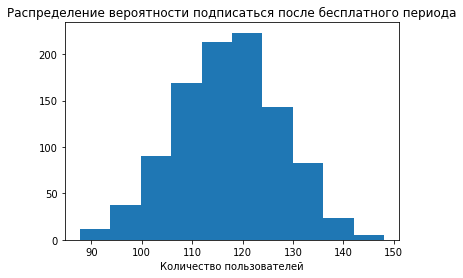

In [23]:
n = 1169 # количество бесплатных подписок
p = 0.1 # вероятность того, что пользователь продолжит подписку
x = 100 # целевое значение клиентов

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

print(f'''Нам необходимо предложить {n} пользователю бесплатную подписку, \
чтобы вероятность получить менее 100 клиентов составляла {distr.cdf(x).round(3) * 100}%''')

distr_plot = np.random.normal(mu, sigma, 1000) 
plt.hist(distr_plot, 10) 
plt.title('Распределение вероятности подписаться после бесплатного периода')
plt.xlabel('Количество пользователей')

plt.show()

### Уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации нужно построить примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность того, что письмо откроют не более 399500 пользователей составляет 15.4%


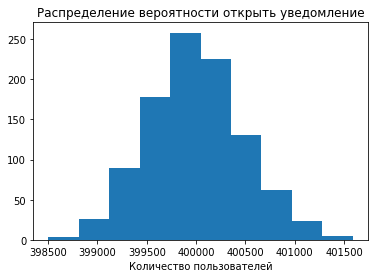

In [24]:
n = 1000000 # количество уведомлений
p = 0.4 # вероятность того, что пользователь откроет уведомление
x = 399500 # целевое значение открытий

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

print(f'''Вероятность того, что письмо откроют не более {x} пользователей составляет {distr.cdf(x).round(3) * 100}%''')

distr_plot = np.random.normal(mu, sigma, 1000) 
plt.hist(distr_plot, 10) 
plt.title('Распределение вероятности открыть уведомление')
plt.xlabel('Количество пользователей')
plt.show()

## Общий вывод

**Что мы сделали:**
- Визуально оценили распределение данных в различных срезах;
- Удалили аномалии, которые могли бы повлиять на корректность выводов;
- Проверили несколько гипотез и оценили запросы отдела маркетинга;

**Выводы:**
- Средний возраст пользователей 25 лет;
- Пользователей с подпиской чуть меньше, чем пользователей без неё;
- В среднем поездка польователей поставляет от 15 до 25 минут;
- У части поездок наблюдаются ошибки с отслеживанием времени поездки. Время поездки - полминуты, при этом большие расстояния;
- Распределение расстояния имеет два пика - один в районе 1000 м. второй - 3000 м. Это наблюдается как у пользователей с подпиской, так и у пользователей без неё;
- Удивительно, но Москва - наименее популярный город среди наших клиентов, а самый популярный - Пятигорск;
- Пользователи с подпиской тратят больше времени на поездки и, как следствие, приносят больше выручки. Такие пользователи выгоднее для компании.
- Среднее расстояние, которое пользователи проезжают за одну поездку действительно не превышает 3130 метров;

**Рекомендации:**
- Следует популяризировать подписку ultra среди пользователей без подписки, а пользователей с подпиской стараться максимально удерживать;
- Нужно выяснить причину ошибки оценки времени поездки и исправить её;
- Нам необходимо предложить 1169 пользователю бесплатную подписку, чтобы вероятность получить менее 100 клиентов составляла 5.0%;
- Вероятность того, что письмо откроют не более 399500 пользователей составляет 15.4%;